In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_squared_error, mean_absolute_percentage_error
from joblib import dump
import os
np.random.seed(42)
print('Libraries loaded.')


Libraries loaded.


In [2]:

# ------------------ GENERATE_SYNTHETIC_DATA ------------------
# We'll create a synthetic dataset representative of a pricing problem.
# Columns: product_id, technical_score (0-100), market_segment (A/B/C),
# competitor_price, cost, demand_index, seasonal_index, offer_status (0/1), price (continuous target)

n = 2000
product_id = np.arange(1, n+1)
technical_score = np.clip(np.random.normal(60, 15, n), 10, 100)
market_segment = np.random.choice(['A','B','C'], size=n, p=[0.4,0.35,0.25])
competitor_price = np.random.normal(50000, 15000, n).clip(10000, 150000)
cost = competitor_price * np.random.uniform(0.6, 0.9, n)
demand_index = np.random.beta(2,5, n) * 100
seasonal_index = 1 + 0.2 * np.sin(np.linspace(0, 6.28, n))  # mild seasonality

# Simulate a "recommended price" influenced by features
base_price = cost * np.random.uniform(1.05, 1.5, n)
price = base_price * (1 + (technical_score-50)/400) * (1 + demand_index/500) * seasonal_index
price = np.round(price, -2)  # round to 100s for realism

# Offer status: whether the offer was accepted (1) or rejected (0) - synthetic rule + noise
prob_accept = 1 / (1 + np.exp(-( (technical_score-50)/10 + (competitor_price-price)/20000 + (demand_index-20)/20 )))
offer_status = (np.random.rand(n) < prob_accept).astype(int)

df = pd.DataFrame({
    'product_id': product_id,
    'technical_score': technical_score,
    'market_segment': market_segment,
    'competitor_price': competitor_price.astype(int),
    'cost': cost.astype(int),
    'demand_index': demand_index,
    'seasonal_index': seasonal_index,
    'price': price.astype(int),
    'offer_status': offer_status
})

df.head()


,product_id,technical_score,market_segment,competitor_price,cost,demand_index,seasonal_index,price,offer_status
0,1,67.450712,B,66025,45752,51.550804,1.000000,64100,1
1,2,57.926035,A,59061,36957,55.476126,1.000628,52700,1
2,3,69.715328,A,84554,53039,21.192504,1.001257,82800,1
3,4,82.845448,A,27808,24386,43.034861,1.001885,38700,1
4,5,56.487699,C,68888,55578,26.624275,1.002513,64200,1


Shape: (2000, 9)


,product_id,technical_score,market_segment,competitor_price,cost,demand_index,seasonal_index,price,offer_status
count,2000.000000,2000.000000,2000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
unique,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,824,NaN,NaN,NaN,NaN,NaN,NaN
mean,1000.500000,60.656392,NaN,49443.541000,36853.412000,28.312588,1.000000,51123.800000,0.713500
std,577.494589,14.766233,NaN,14763.701559,11848.296474,15.527224,0.141457,19010.073777,0.452239
min,1.000000,11.380990,NaN,10000.000000,6093.000000,0.647603,0.800000,7800.000000,0.000000
25%,500.750000,50.660071,NaN,39687.000000,28726.000000,16.709425,0.858580,37500.000000,0.000000
50%,1000.500000,60.670375,NaN,49686.000000,36587.000000,26.115271,1.000002,49600.000000,1.000000
75%,1500.250000,70.244664,NaN,59500.250000,44635.500000,38.155342,1.141421,62300.000000,1.000000


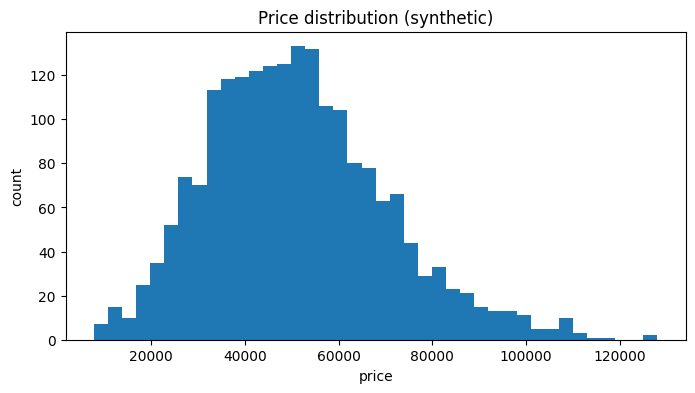

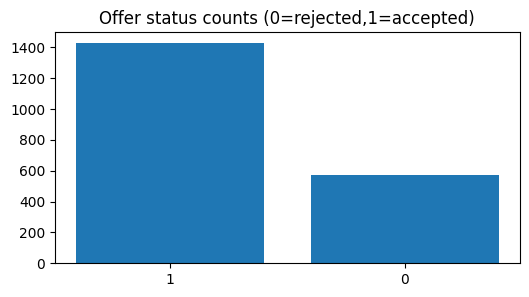

In [3]:

# Basic EDA
print('Shape:', df.shape)
display(df.describe(include='all'))

# Plot price distribution and offer status counts
plt.figure(figsize=(8,4))
plt.hist(df['price'], bins=40)
plt.title('Price distribution (synthetic)')
plt.xlabel('price')
plt.ylabel('count')
plt.show()

plt.figure(figsize=(6,3))
plt.bar(df['offer_status'].value_counts().index.astype(str), df['offer_status'].value_counts().values)
plt.title('Offer status counts (0=rejected,1=accepted)')
plt.show()


In [4]:

# Preprocessing
X = df.drop(columns=['product_id','offer_status','price'])
y_clf = df['offer_status']
y_reg = df['price']

numeric_features = ['technical_score','competitor_price','cost','demand_index','seasonal_index']
categorical_features = ['market_segment']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Classification pipeline
clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)
print('Classification accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))


Classification accuracy: 0.7875

Classification report:
               precision    recall  f1-score   support

           0       0.71      0.43      0.54       115
           1       0.80      0.93      0.86       285

    accuracy                           0.79       400
   macro avg       0.76      0.68      0.70       400
weighted avg       0.78      0.79      0.77       400



In [7]:
# Regression: predict price
X_r = df.drop(columns=['product_id','price','offer_status'])
y_r = df['price']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('reg', RandomForestRegressor(n_estimators=150, random_state=42))])

reg_pipeline.fit(Xr_train, yr_train)
yr_pred = reg_pipeline.predict(Xr_test)
print('Regression R2:', r2_score(yr_test, yr_pred))
print('RMSE:', np.sqrt(mean_squared_error(yr_test, yr_pred)))
print('MAPE:', mean_absolute_percentage_error(yr_test, yr_pred))

Regression R2: 0.899418350560434
RMSE: 6034.766043702293
MAPE: 0.09615588141295398


In [8]:

# Create artifacts folder and save models
os.makedirs('artifacts', exist_ok=True)
dump(clf_pipeline, 'artifacts/offer_status_classifier.joblib')
dump(reg_pipeline, 'artifacts/price_regressor.joblib')
df.sample(200).to_csv('artifacts/sample_synthetic_data.csv', index=False)
print('Saved models and a sample CSV in artifacts/.')


Saved models and a sample CSV in artifacts/.
